# Residence Time Distribution Analysis

## Learning Objectives
- Calculate residence time distributions from aquifer pore volume distributions
- Understand the difference between infiltration to extraction and extraction to infiltration residence time perspectives
- Analyze temporal variations in groundwater residence times
- Apply residence time concepts to contaminant transport and water quality assessment

## Overview

This notebook demonstrates how to calculate residence time distributions from aquifer pore volume distributions and flow rates. Residence time quantifies how long water spends in the aquifer, which is crucial for understanding contaminant transport, groundwater vulnerability, and treatment efficiency.

### Applications
- Contaminant transport predictions
- Groundwater vulnerability assessment  
- Treatment efficiency evaluation
- Water quality forecasting
- Well capture zone analysis

### Two Perspectives
- **Infiltration to Extraction**: How long until infiltrating water is extracted?
- **Extraction to Infiltration**: How long ago was extracted water infiltrated?

### Key Assumptions
- Stationary pore volume distribution
- Advection-dominated transport
- Known aquifer heterogeneity (from Example 1)
- Conservative tracer behavior

### Background Reading
- [Residence Time](https://gwtransport.github.io/gwtransport/user_guide/concepts.html#concept-residence-time) - Time in aquifer between infiltration and extraction
- [Pore Volume Distribution](https://gwtransport.github.io/gwtransport/user_guide/concepts.html#concept-pore-volume-distribution) - Aquifer heterogeneity modeling
- [Retardation Factor](https://gwtransport.github.io/gwtransport/user_guide/concepts.html#concept-retardation-factor) - Slower movement due to sorption

## Theoretical Background

### Residence Time Fundamentals

Residence time in groundwater systems represents the travel time of water through the aquifer:

$$t_{residence} = \frac{V_{pore}}{Q} \cdot R_f$$

Where:
- $V_{pore}$: Pore volume along flow path [m³]
- $Q$: Flow rate [m³/day]
- $R_f$: Retardation factor [-] (1.0 for water, >1.0 for reactive tracers)

### Infiltration to Extraction vs. Extraction to Infiltration Analysis

**Infiltration to Extraction Residence Time**: Starting from infiltration time, calculates when water will be extracted
- Used for: Contaminant arrival time predictions
- Question: "When will this contamination reach the well?"

**Extraction to Infiltration Residence Time**: Starting from extraction time, calculates when water was infiltrated
- Used for: Source identification and age dating
- Question: "How old is the water we're extracting now?"

### Temporal Variability

Residence times vary over time due to:
- Seasonal flow rate changes
- Aquifer heterogeneity
- Extraction rate variations

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from gwtransport import gamma as gamma_utils
from gwtransport.examples import generate_example_data
from gwtransport.residence_time import residence_time

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Setup and Aquifer Parameters

We use aquifer parameters typically obtained from Example 1 (temperature-based characterization) and generate flow data for residence time analysis.

In [2]:
df, tedges = generate_example_data(
    date_start="2020-01-01",
    date_end="2025-05-31",
    flow_mean=120.0,  # Base flow rate [m³/day]
    flow_amplitude=40.0,  # Seasonal flow variation [m³/day]
    flow_noise=5.0,  # Random daily fluctuations [m³/day]
    temp_infiltration_method="soil_temperature",  # Use real soil temperature data
    aquifer_pore_volume_gamma_mean=8000.0,  # True mean pore volume [m³]
    aquifer_pore_volume_gamma_std=400.0,  # True standard deviation [m³]
    retardation_factor=2.0,  # Thermal retardation factor [-]
)

print("Dataset Summary:")
print(f"Period: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Mean flow: {df['flow'].mean():.1f} m³/day")
print(f"Flow range: {df['flow'].min():.1f} - {df['flow'].max():.1f} m³/day")
print(
    f"Aquifer parameters: {df.attrs['aquifer_pore_volume_gamma_mean']:.0f} ± {df.attrs['aquifer_pore_volume_gamma_std']:.0f} m³"
)

print("Dataset Summary:")
print(f"Period: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Mean flow: {df['flow'].mean():.1f} m³/day")
print(f"Mean infiltration temperature: {df['temp_infiltration'].mean():.1f} °C")
print(f"Mean extraction temperature: {df['temp_extraction'].mean():.1f} °C")
print(f"True mean pore volume: {df.attrs['aquifer_pore_volume_gamma_mean']:.1f} m³")
print(f"True std deviation: {df.attrs['aquifer_pore_volume_gamma_std']:.1f} m³")

Dataset Summary:
Period: 2020-01-01 to 2025-05-31
Mean flow: 105.2 m³/day
Flow range: 8.1 - 170.0 m³/day
Aquifer parameters: 8000 ± 400 m³
Dataset Summary:
Period: 2020-01-01 to 2025-05-31
Mean flow: 105.2 m³/day
Mean infiltration temperature: 11.8 °C
Mean extraction temperature: 12.0 °C
True mean pore volume: 8000.0 m³
True std deviation: 400.0 m³


In [3]:
# Discretize pore volume distribution for residence time calculation
n_bins = 1000  # High resolution for accurate calculations
bins = gamma_utils.bins(
    mean=df.attrs["aquifer_pore_volume_gamma_mean"], std=df.attrs["aquifer_pore_volume_gamma_std"], n_bins=n_bins
)

print(f"Pore volume distribution discretized into {n_bins} bins")
print(f"Bin range: {bins['expected_values'].min():.0f} - {bins['expected_values'].max():.0f} m³")
print(
    f"Mean residence time (no retardation): {df.attrs['aquifer_pore_volume_gamma_mean'] / df['flow'].mean():.1f} days"
)
print(
    f"Mean residence time (with retardation): {df.attrs['aquifer_pore_volume_gamma_mean'] / df['flow'].mean() * df.attrs['retardation_factor']:.1f} days"
)

Pore volume distribution discretized into 1000 bins
Bin range: 6722 - 9417 m³
Mean residence time (no retardation): 76.0 days
Mean residence time (with retardation): 152.0 days


## 2. Infiltration to Extraction Residence Time Analysis

Calculate how long infiltrating water takes to be extracted. We compute residence times for both water flow (conservative tracer) and thermal transport (with retardation).

In [4]:
print("Computing infiltration to extraction residence times...")

# Water residence time (no retardation)
rt_infiltration_to_extraction_water = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volumes=bins["expected_values"],
    retardation_factor=1.0,  # Conservative tracer (water flow)
    direction="infiltration_to_extraction",
)

# Thermal residence time (with retardation)
rt_infiltration_to_extraction_thermal = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volumes=bins["expected_values"],
    retardation_factor=df.attrs["retardation_factor"],  # Heat transport (slower)
    direction="infiltration_to_extraction",
)

print(f"Infiltration to extraction residence time arrays shape: {rt_infiltration_to_extraction_water.shape}")
print(
    f"({rt_infiltration_to_extraction_water.shape[0]} flow paths x {rt_infiltration_to_extraction_water.shape[1]} time steps)"
)

Computing infiltration to extraction residence times...
Infiltration to extraction residence time arrays shape: (1000, 1978)
(1000 flow paths x 1978 time steps)


In [5]:
# Statistical analysis of residence time distributions
quantiles = [1, 10, 90, 99]  # Percentiles for uncertainty bounds
quantile_headers = [f"rt_infiltration_to_extraction_water_{q}%" for q in quantiles]

with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message="Mean of empty slice")
    warnings.filterwarnings(action="ignore", message="All-NaN slice encountered")

    # Calculate mean residence times
    df["rt_infiltration_to_extraction_water_mean"] = np.nanmean(rt_infiltration_to_extraction_water, axis=0)
    df["rt_infiltration_to_extraction_thermal_mean"] = np.nanmean(rt_infiltration_to_extraction_thermal, axis=0)

    # Calculate percentiles for uncertainty analysis
    df[quantile_headers] = np.nanpercentile(rt_infiltration_to_extraction_water, quantiles, axis=0).T

print("Infiltration to extraction residence time statistics calculated")
print(f"Mean water residence time: {df['rt_infiltration_to_extraction_water_mean'].mean():.1f} days")
print(f"Mean thermal residence time: {df['rt_infiltration_to_extraction_thermal_mean'].mean():.1f} days")
print(
    f"Retardation effect: {df['rt_infiltration_to_extraction_thermal_mean'].mean() / df['rt_infiltration_to_extraction_water_mean'].mean():.1f}x"
)
print(
    f"({rt_infiltration_to_extraction_water.shape[0]} flow paths x {rt_infiltration_to_extraction_water.shape[1]} time steps)"
)

Infiltration to extraction residence time statistics calculated
Mean water residence time: 77.9 days
Mean thermal residence time: 151.6 days
Retardation effect: 1.9x
(1000 flow paths x 1978 time steps)


## 3. Infiltration to Extraction Residence Time Visualization

Visualize how residence times vary over time and compare water vs. thermal transport.

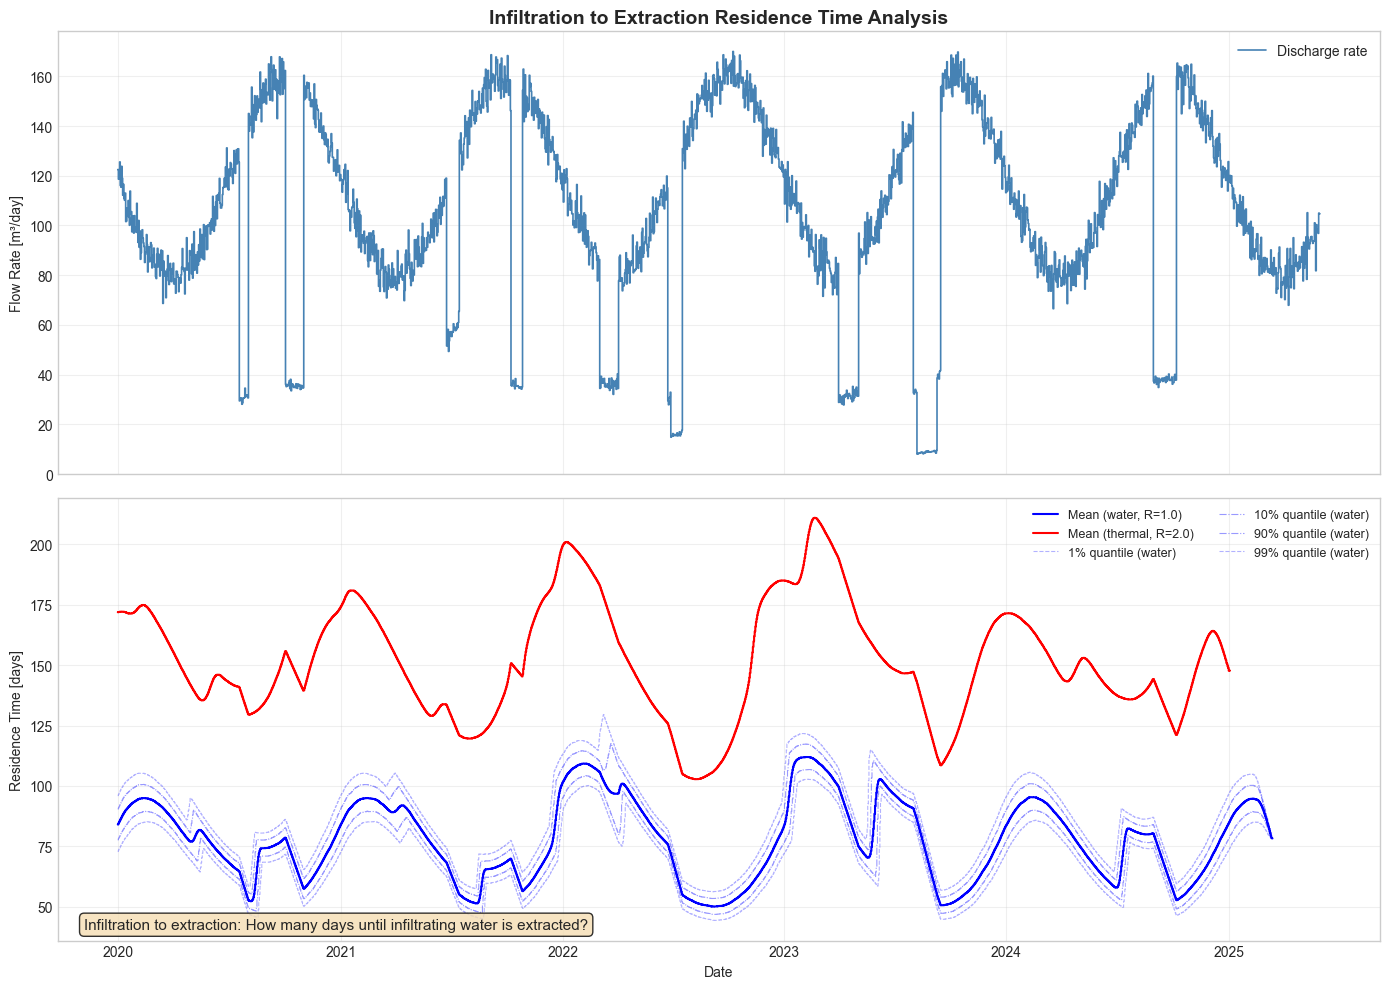

Infiltration to extraction residence time plot saved to: 02_Infiltration_to_Extraction_residence_time.png


In [6]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Flow rate subplot - convert to step format
xstep_flow, ystep_flow = np.repeat(tedges, 2)[1:-1], np.repeat(df.flow, 2)
ax[0].plot(xstep_flow, ystep_flow, label="Discharge rate", color="steelblue", linewidth=1.2)
ax[0].set_ylabel("Flow Rate [m³/day]")
ax[0].set_title("Infiltration to Extraction Residence Time Analysis", fontsize=14, fontweight="bold")
ax[0].legend(loc="upper right")
ax[0].grid(True, alpha=0.3)

# Residence time subplot - convert all series to step format
xstep_rt, ystep_rt_water = np.repeat(tedges, 2)[1:-1], np.repeat(df.rt_infiltration_to_extraction_water_mean, 2)
_, ystep_rt_thermal = np.repeat(tedges, 2)[1:-1], np.repeat(df.rt_infiltration_to_extraction_thermal_mean, 2)

ax[1].plot(
    xstep_rt,
    ystep_rt_water,
    label="Mean (water, R=1.0)",
    color="blue",
    linewidth=1.5,
)
ax[1].plot(
    xstep_rt,
    ystep_rt_thermal,
    label=f"Mean (thermal, R={df.attrs['retardation_factor']:.1f})",
    color="red",
    linewidth=1.5,
)

# Add uncertainty bounds
for q in quantiles:
    alpha_val = 0.4 if q in {10, 90} else 0.3
    linestyle = "--" if q in {1, 99} else "-."
    _, ystep_quantile = np.repeat(tedges, 2)[1:-1], np.repeat(df[f"rt_infiltration_to_extraction_water_{q}%"], 2)
    ax[1].plot(
        xstep_rt,
        ystep_quantile,
        label=f"{q}% quantile (water)",
        color="blue",
        alpha=alpha_val,
        linewidth=0.8,
        linestyle=linestyle,
    )

ax[1].set_ylabel("Residence Time [days]")
ax[1].set_xlabel("Date")
ax[1].legend(loc="upper right", ncol=2, fontsize=9)
ax[1].grid(True, alpha=0.3)

# Add explanatory text
ax[1].text(
    0.02,
    0.02,
    "Infiltration to extraction: How many days until infiltrating water is extracted?",
    ha="left",
    va="bottom",
    transform=ax[1].transAxes,
    fontsize=11,
    bbox={"boxstyle": "round,pad=0.3", "facecolor": "wheat", "alpha": 0.8},
)

plt.tight_layout()

# Save the infiltration to extraction residence time plot
out_path = Path("02_Infiltration_to_Extraction_residence_time.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Infiltration to extraction residence time plot saved to: {out_path}")

## 4. Extraction to Infiltration Residence Time Analysis

Calculate when currently extracted water was originally infiltrated. This perspective is crucial for source identification and age dating.

In [7]:
print("Computing extraction to infiltration residence times...")

# Water residence time (no retardation)
rt_extraction_to_infiltration_water = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volumes=bins["expected_values"],
    retardation_factor=1.0,
    direction="extraction_to_infiltration",
)

# Thermal residence time (with retardation)
rt_extraction_to_infiltration_thermal = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volumes=bins["expected_values"],
    retardation_factor=df.attrs["retardation_factor"],
    direction="extraction_to_infiltration",
)

print(f"Extraction to infiltration residence time arrays shape: {rt_extraction_to_infiltration_water.shape}")

Computing extraction to infiltration residence times...
Extraction to infiltration residence time arrays shape: (1000, 1978)


In [8]:
# Statistical analysis for extraction to infiltration residence times
quantile_headers_extraction_to_infiltration = [f"rt_extraction_to_infiltration_water_{q}%" for q in quantiles]

with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message="Mean of empty slice")
    warnings.filterwarnings(action="ignore", message="All-NaN slice encountered")

    # Calculate mean residence times
    df["rt_extraction_to_infiltration_water_mean"] = np.nanmean(rt_extraction_to_infiltration_water, axis=0)
    df["rt_extraction_to_infiltration_thermal_mean"] = np.nanmean(rt_extraction_to_infiltration_thermal, axis=0)

    # Calculate percentiles
    df[quantile_headers_extraction_to_infiltration] = np.nanpercentile(
        rt_extraction_to_infiltration_water, quantiles, axis=0
    ).T

print("Extraction to infiltration residence time statistics calculated")
print(
    f"Mean extraction to infiltration water residence time: {df['rt_extraction_to_infiltration_water_mean'].mean():.1f} days"
)
print(
    f"Mean extraction to infiltration thermal residence time: {df['rt_extraction_to_infiltration_thermal_mean'].mean():.1f} days"
)

Extraction to infiltration residence time statistics calculated
Mean extraction to infiltration water residence time: 77.9 days
Mean extraction to infiltration thermal residence time: 151.6 days


## 5. Extraction to Infiltration Residence Time Visualization

Show how the age of extracted water varies over time, revealing the temporal dynamics of groundwater flow.

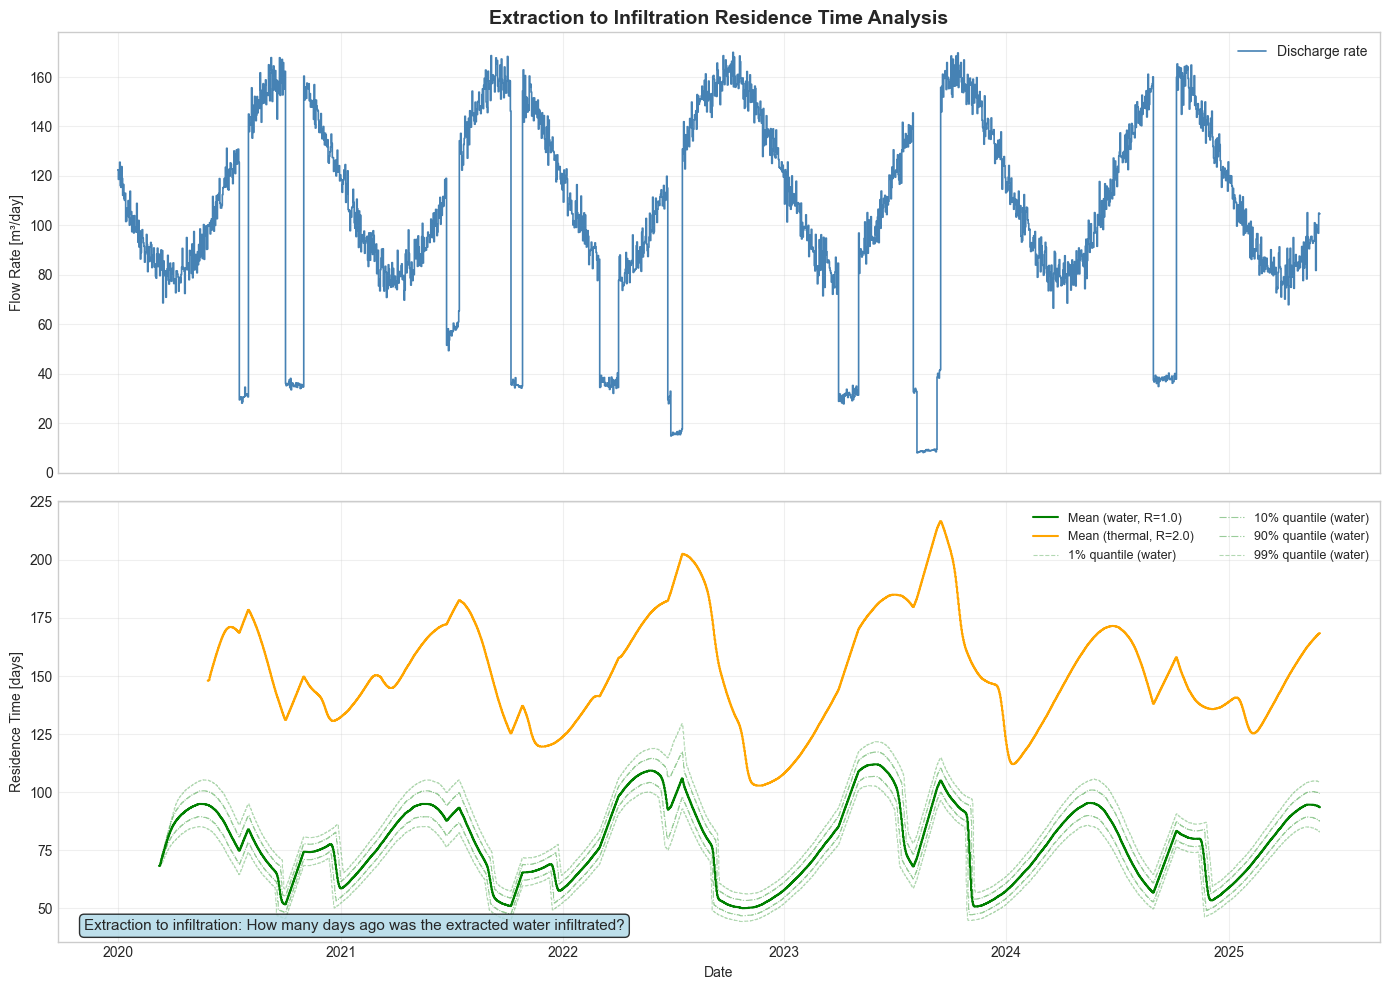

Extraction to infiltration residence time plot saved to: 02_Extraction_to_Infiltration_residence_time.png


In [9]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Flow rate subplot - convert to step format
xstep_flow, ystep_flow = np.repeat(tedges, 2)[1:-1], np.repeat(df.flow, 2)
ax[0].plot(xstep_flow, ystep_flow, label="Discharge rate", color="steelblue", linewidth=1.2)
ax[0].set_ylabel("Flow Rate [m³/day]")
ax[0].set_title("Extraction to Infiltration Residence Time Analysis", fontsize=14, fontweight="bold")
ax[0].legend(loc="upper right")
ax[0].grid(True, alpha=0.3)

# Residence time subplot - convert all series to step format
xstep_rt, ystep_rt_water = np.repeat(tedges, 2)[1:-1], np.repeat(df.rt_extraction_to_infiltration_water_mean, 2)
_, ystep_rt_thermal = np.repeat(tedges, 2)[1:-1], np.repeat(df.rt_extraction_to_infiltration_thermal_mean, 2)

ax[1].plot(
    xstep_rt,
    ystep_rt_water,
    label="Mean (water, R=1.0)",
    color="green",
    linewidth=1.5,
)
ax[1].plot(
    xstep_rt,
    ystep_rt_thermal,
    label=f"Mean (thermal, R={df.attrs['retardation_factor']:.1f})",
    color="orange",
    linewidth=1.5,
)

# Add uncertainty bounds for water
for q in quantiles:
    alpha_val = 0.4 if q in {10, 90} else 0.3
    linestyle = "--" if q in {1, 99} else "-."
    _, ystep_quantile = np.repeat(tedges, 2)[1:-1], np.repeat(df[f"rt_extraction_to_infiltration_water_{q}%"], 2)
    ax[1].plot(
        xstep_rt,
        ystep_quantile,
        label=f"{q}% quantile (water)",
        color="green",
        alpha=alpha_val,
        linewidth=0.8,
        linestyle=linestyle,
    )

ax[1].set_ylabel("Residence Time [days]")
ax[1].set_xlabel("Date")
ax[1].legend(loc="upper right", ncol=2, fontsize=9)
ax[1].grid(True, alpha=0.3)

# Add explanatory text
ax[1].text(
    0.02,
    0.02,
    "Extraction to infiltration: How many days ago was the extracted water infiltrated?",
    ha="left",
    va="bottom",
    transform=ax[1].transAxes,
    fontsize=11,
    bbox={"boxstyle": "round,pad=0.3", "facecolor": "lightblue", "alpha": 0.8},
)

plt.tight_layout()

# Save the extraction to infiltration residence time plot
out_path = Path("02_Extraction_to_Infiltration_residence_time.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Extraction to infiltration residence time plot saved to: {out_path}")

## Results & Discussion

### Flow Rate Dependencies
Residence times show strong inverse correlation with flow rates:
- **High flows**: Shorter residence times, faster transport
- **Low flows**: Longer residence times, more retention

### Infiltration to Extraction vs. Extraction to Infiltration Perspectives
- **Similar mean values**: Both perspectives yield comparable average residence times
- **Different temporal patterns**: Timing of variability differs due to flow history effects
- **Practical applications**: Choose perspective based on specific management question

### Retardation Effects
Thermal retardation factor of 2.0 effectively doubles residence times:
- Important for temperature-based tracer studies
- Affects timing of thermal breakthrough
- Must be considered in heat transport applications

### Engineering Applications

**Contaminant Transport**:
- Use infiltration to extraction analysis for spill response planning
- Use extraction to infiltration analysis for source identification

**Well Field Design**:
- Optimize pumping rates based on residence time requirements
- Consider seasonal flow variations in planning

**Water Quality Management**:
- Predict arrival times of contaminants
- Assess natural attenuation potential
- Design monitoring networks

## Key Takeaways

✅ **Two Perspectives**: Infiltration to extraction and extraction to infiltration residence times answer different but complementary questions

✅ **Flow Rate Control**: Higher flows lead to shorter residence times and faster transport

✅ **Temporal Variability**: Residence times vary seasonally due to flow rate changes

✅ **Retardation Effects**: Must account for tracer-specific retardation in transport analysis

✅ **Uncertainty Quantification**: Use percentile analysis to capture aquifer heterogeneity effects

✅ **Practical Applications**: Choose analysis perspective based on specific management objectives